## Check the dependecy on sigma (Penaltity) on the best-Fit Nuisance Parameter

In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-11-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
from MapDatasetNuisanceE import MapDatasetNuisanceE
from  my_fit_20 import Fit
import my_dataset_core_20_e , my_fit_20_e
from Dataset_Creation import sys_dataset


In [3]:
from  my_fit_20_e import Registry
registry= Registry()

def covariance_ (fit_compute, datasets_compute):
    parameters = Parameters.from_stack([datasets_compute.models.parameters, 
                                        datasets_compute.N_parameters])
    parameters = parameters.free_parameters
    kwargs = fit_compute.covariance_opts.copy()
    kwargs["minuit"] = fit_compute.minuit
    backend = kwargs.pop("backend", fit_compute.backend)
    compute = registry.get("covariance", backend)

    with parameters.restore_status():
        if fit_compute.backend == "minuit":
            method = "hesse"
        else:
            method = ""
        factor_matrix, info = compute(
            parameters=parameters, function=datasets_compute.stat_sum, **kwargs
        )
        covariance = Covariance.from_factor_matrix(
            parameters=parameters, matrix=factor_matrix
        )

        #covariance = covariance.get_subcovariance(datasets_compute.models.parameters)
    return covariance

## Read dataset

In [4]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy(name="Source"))
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)



spatial binsize =  [0.08] deg


In [5]:
factor_pos = +0.1
sigmas = np.linspace(0,0.2,5)
sigmas = np.insert(sigmas, 0, -0.05)
print(sigmas)
labels_x = ['Standard'] + [str(i) for i in sigmas[1:]]
labels_x[4] = str(0.15)
print(labels_x)

[-0.05  0.    0.05  0.1   0.15  0.2 ]
['Standard', '0.0', '0.05', '0.1', '0.15', '0.2']


In [6]:
datasets = []
for i, sigma in enumerate(sigmas):
    sys = sys_dataset(dataset_asimov, factor_pos,False )
    data = sys.create_dataset_N(sigma)
    if i ==0:
        data.N_parameters[0].frozen = True
    datasets.append(data)     

In [7]:
%%time

fitting = False

if fitting:
    nui_err_all_N = []
    for i, dataset in enumerate(datasets):
        print("Fitting dataset number ", i, " ... ", dataset.penalty_sigma)
        print("Stat sum before ",  dataset.stat_sum())
        
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([dataset])
        if dataset.N_parameters[0].frozen == False:
            covariance  = covariance_(fit_cor, dataset)
            eff_area_error = np.sqrt(covariance.get_subcovariance([dataset.N_parameters[0]]))
        else:
            eff_area_error = np.nan
        nui_err_all_N.append(float(eff_area_error))
        print("Stat sum afer ",  dataset.stat_sum(), "  nui:",dataset.N_parameters[0].value , "pm", eff_area_error )
        
    nui_all_N = []
    norm_all_N = []
    norm_err_all_N = []
    amplitude_all_N = []
    amplitude_err_all_N = []
    stat_all_N = []
    
    
    for dataset in datasets:
        nui_all_N.append(float(dataset.N_parameters.value[0]))
        norm_all_N.append(float(dataset.models.parameters['norm'].value))
        norm_err_all_N.append(float(dataset.models.parameters['norm'].error))
        amplitude_all_N.append(float(dataset.models.parameters['amplitude'].value))
        amplitude_err_all_N.append(float(dataset.models.parameters['amplitude'].error))
        stat_all_N.append(float(dataset.stat_sum()))
        
                          
    print("saving ... ")    
    with open('data/4_nui_all_N.yaml', 'w') as file:
        documents = yaml.dump(nui_all_N, file)
    with open('data/4_nui_err_all_N.yaml', 'w') as file:
        documents = yaml.dump(nui_err_all_N, file)
    with open('data/4_norm_all_N.yaml', 'w') as file:
        documents = yaml.dump(norm_all_N, file)
    with open('data/4_norm_err_all_N.yaml', 'w') as file:
        documents = yaml.dump(norm_err_all_N, file)
    with open('data/4_amplitude_all_N.yaml', 'w') as file:
        documents = yaml.dump(amplitude_all_N, file)
    with open('data/4_amplitude_err_all_N.yaml', 'w') as file:
        documents = yaml.dump(amplitude_err_all_N, file)
    with open('data/stat_all_N.yaml', 'w') as file:
        documents = yaml.dump(stat_all_N, file)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [8]:
if fitting == False:
    print("reading ... ")    
    
    with open('data/4_nui_all_N.yaml') as file:
        nui_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_nui_err_all_N.yaml') as file:
        nui_err_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_norm_all_N.yaml') as file:
        norm_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_norm_err_all_N.yaml') as file:
        norm_err_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_amplitude_all_N.yaml') as file:
        amplitude_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_amplitude_err_all_N.yaml') as file:
        amplitude_err_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/stat_all_N.yaml') as file:
        stat_all_N = yaml.load( file, Loader=yaml.FullLoader)


reading ... 


## Check the order of parameters and the covariance matrix!! 

/tmp/ipykernel_2143297/515042239.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  pen = nui_all_N[i]**2 / d.penalty_sigma


Text(0.5, 0, 'Penalty Sigma')

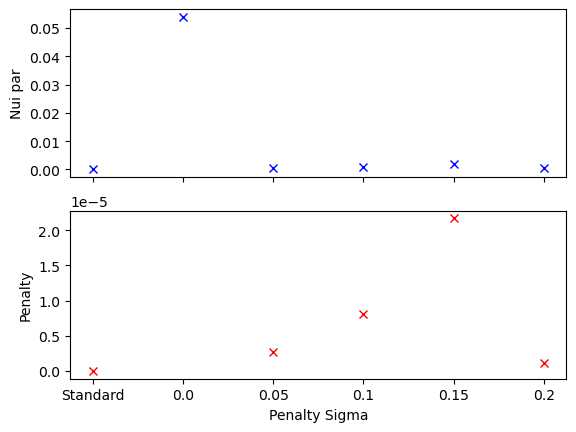

In [9]:
fig , axs = plt.subplots(2,1, sharex=True)

for i, d in enumerate(datasets):
    #print("for sigma: ", sigmas[i], ": stat sum:" , d.stat_sum())
    axs[0].plot(sigmas[i], nui_all_N[i], 'x', color = 'blue')
    pen = nui_all_N[i]**2 / d.penalty_sigma
    #print('   pen:', pen)
    #print("   N:", nui_all_N[i])
    axs[1].plot(sigmas[i], pen, 'x', color = 'red')
axs[0].set_xticks(sigmas,labels_x)    
axs[1].set_xticks(sigmas,labels_x)    
axs[0].set_ylabel("Nui par")
axs[1].set_ylabel("Penalty")
axs[1].set_xlabel("Penalty Sigma")

Text(0.5, 0, 'Penalty Sigma')

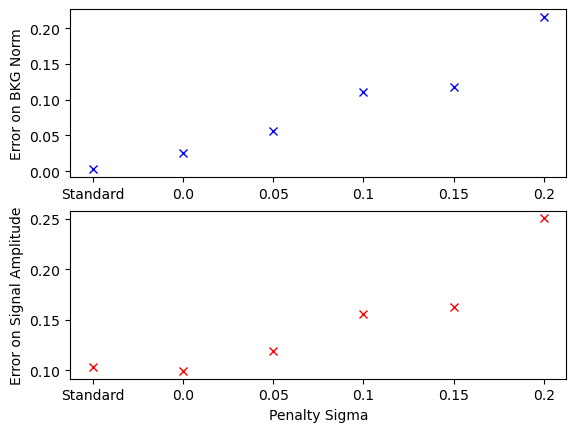

In [10]:
fig , axs = plt.subplots(2,1)

for i, d in enumerate(datasets):
    axs[0].plot(sigmas[i], norm_err_all_N[i], 'x', color = 'blue')
    axs[1].plot(sigmas[i], np.array(amplitude_err_all_N[i])/1e-12, 'x', color = 'red')
axs[0].set_xticks(sigmas,labels_x)    
axs[1].set_xticks(sigmas,labels_x)    
axs[0].set_ylabel("Error on BKG Norm")
axs[1].set_ylabel("Error on Signal Amplitude")
axs[1].set_xlabel("Penalty Sigma")

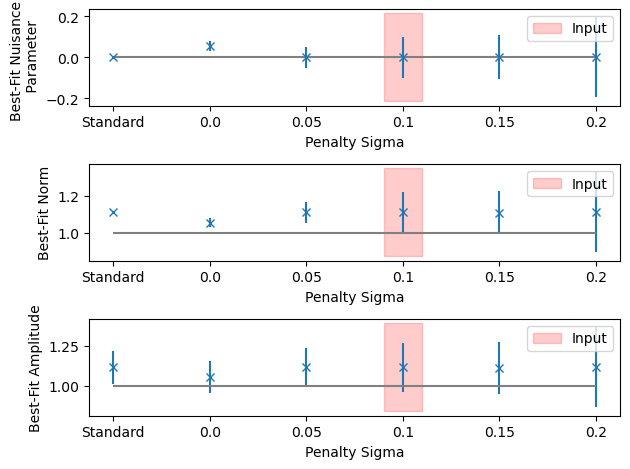

In [12]:
fig,ax = plt.subplots(3,1)

ax[0].errorbar(x = sigmas, y = nui_all_N, yerr= nui_err_all_N,  fmt='x', )
ax[0].set_xlabel("Penalty Sigma")
ax[0].set_ylabel("Best-Fit Nuisance \n Parameter")
ax[0].hlines(0, np.min(sigmas),np.max(sigmas), label = "", color = 'grey')
ax[0].fill_between(  [factor_pos- 0.01, factor_pos+0.01], ax[0].get_ylim()[0], ax[0].get_ylim()[1],
                  label = "Input", color = 'red', alpha = 0.2)

ax[1].errorbar(x = sigmas, y = norm_all_N, yerr= norm_err_all_N,  fmt='x', )
ax[1].set_xlabel("Penalty Sigma")
ax[1].set_ylabel("Best-Fit Norm")
ax[1].hlines(1, np.min(sigmas),np.max(sigmas), label = "", color = 'grey')
ax[1].fill_between(  [factor_pos- 0.01, factor_pos+0.01], ax[1].get_ylim()[0], ax[1].get_ylim()[1],
                  label = "Input", color = 'red', alpha = 0.2)

ax[2].errorbar(x = sigmas, y = np.array(amplitude_all_N) /1e-12, yerr= np.array(amplitude_err_all_N) /1e-12,
               fmt='x', )
ax[2].set_xlabel("Penalty Sigma")
ax[2].set_ylabel("Best-Fit Amplitude")
ax[2].hlines(1, np.min(sigmas),np.max(sigmas), label = "", color = 'grey')
ax[2].fill_between(  [factor_pos- 0.01, factor_pos+0.01], ax[2].get_ylim()[0], ax[2].get_ylim()[1],
                  label = "Input", color = 'red', alpha = 0.2)

for axx in ax:
    axx.legend()
    axx.set_xticks(sigmas,labels_x)    
plt.tight_layout()
fig.savefig("plots/4_nui_vs_sigma.png")